(8192, 2)
Epoch 1/20
Tensor("Placeholder:0", shape=(256, 2), dtype=float32)
32/32 [==============================] - 90s 190ms/step - loss: 1.9212
Epoch 2/20
32/32 [==============================] - 8s 247ms/step - loss: 1.5841
Epoch 3/20
32/32 [==============================] - 8s 242ms/step - loss: 1.4942
Epoch 4/20
32/32 [==============================] - 8s 243ms/step - loss: 1.3813
Epoch 5/20
32/32 [==============================] - 9s 270ms/step - loss: 1.1718
Epoch 6/20
32/32 [==============================] - 8s 261ms/step - loss: 1.1024
Epoch 7/20
32/32 [==============================] - 9s 268ms/step - loss: 1.0302
Epoch 8/20
32/32 [==============================] - 8s 264ms/step - loss: 0.9916
Epoch 9/20
32/32 [==============================] - 9s 266ms/step - loss: 1.0537
Epoch 10/20
32/32 [==============================] - 9s 282ms/step - loss: 0.8782
Epoch 11/20
32/32 [==============================] - 9s 293ms/step - loss: 0.9011
Epoch 12/20
32/32 [======================

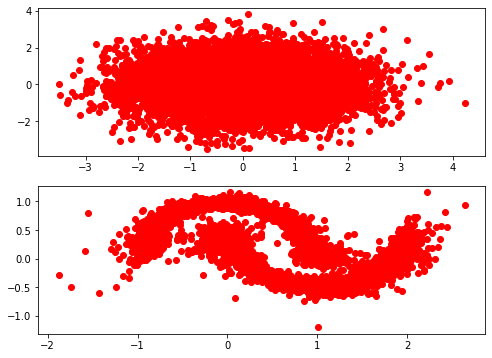

In [9]:
import numpy as np
import os,re
import sklearn.datasets as skd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions


class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)
        
    @tf.function
    def call(self, t, data):
        #We add time to each transformation so they are parameterized for time
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data], -1)
        return self._model(inputs)
        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        #trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,              
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs):
        return self.flow.bijector.forward(inputs)
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x):
        print(_x)
        loss = -tf.reduce_mean(self.flow.log_prob(_x))
        return loss
    
    
    @tf.function()
    def train_step(self, data):
        #Full shape needs to be given when using tf.dataset
        data.set_shape((self._batch_size,self._num_output))
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, data):
        #Full shape needs to be given when using tf.dataset
        data.set_shape((self._batch_size,self._num_output))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


if __name__ == '__main__':

    LR = 1e-2
    NUM_EPOCHS = 20
    STACKED_FFJORDS = 4 #Number of stacked transformations
    NUM_LAYERS = 8 #Hiddden layers per bijector
    NUM_OUTPUT = 2 #Output dimension
    NUM_HIDDEN = 4*NUM_OUTPUT #Hidden layer node size

    
    #Target dataset: half moon
    DATASET_SIZE = 1024 * 8
    BATCH_SIZE = 256 

    moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0].astype("float32")
    print(moons.shape)
    
    #Stack of bijectors 
    stacked_mlps = []
    for _ in range(STACKED_FFJORDS):
        mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
        stacked_mlps.append(mlp_model)

    #Create the model
    model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
    
    history = model.fit(
        moons,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose=1,
    )

    NSAMPLES = 10000
    #Sample the learned distribution
    base_distribution = model.base_distribution.sample(NSAMPLES)
    transformed = model.flow.sample(NSAMPLES)
    
    #Plotting    
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.scatter(base_distribution[:, 0], base_distribution[:, 1], color="r")
    plt.subplot(212)
    plt.scatter(transformed[:, 0], transformed[:, 1], color="r")
    plot_folder = '../plots'
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)
    
    fig.savefig('{}/double_moon.pdf'.format(plot_folder))

In [11]:
# Log probability for point (0, 0.5)?
model.base_distribution.log_prob([0,0.5])

<tf.Tensor: shape=(), dtype=float32, numpy=-1.962877>

In [53]:
# Transformed coordinate of (-0.1, 0.6) in the normal distribution?
temp = np.zeros([1,2], dtype='float32')
temp[0] = [-0.1, 0.6]
temp
#model.chain.forward(temp)

# I don't know if this is correct at all, but it looks like the answer is (0.423, 0.843)?
# Even if this is correct, this is certainly not the best way to do it... I couldn't
# figure out how to call forward() on just one point, and had to create this tf.Tensor
# with (-0.1, 0.6) as the first element to call forward() on it. What is the best way to
# actually do this?

# Thanks to Ben and Vinny's help, I figured out that you could in fact call forward()
# on a single point, but it needs to be like this:
model.chain.forward([[-0.1,0.6]])

array([[-0.1,  0.6]], dtype=float32)

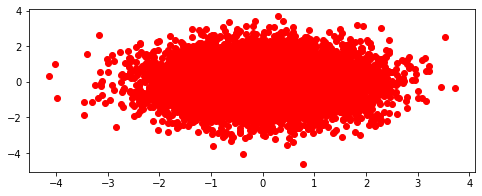

In [36]:
# Revert samples from double moon distribution using inverse
inversed = model.chain.inverse(transformed)

fig2 = plt.figure(figsize=(8, 3))
plt.scatter(inversed[:, 0], inversed[:, 1], color="r")

# It looks like a normal distribution again!

In [57]:
transformed

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[-0.8265002 ,  0.68157065],
       [ 0.5299471 , -0.32267785],
       [-0.02945252, -0.11661252],
       ...,
       [-0.36178988,  1.0878217 ],
       [ 1.599465  , -0.6032721 ],
       [-0.7990341 ,  0.6188802 ]], dtype=float32)>